In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18112514834841675944
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11326380442
locality {
  bus_id: 1
}
incarnation: 10539206391599429748
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:06:00.0"
, name: "/gpu:1"
device_type: "GPU"
memory_limit: 11324388148
locality {
  bus_id: 1
}
incarnation: 17990026548815363763
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:07:00.0"
]


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

# Building Network

## Step 2: Building a Model
### Adding a densely connected classifier on top of the convolutional base

In [2]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(90, 80, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 90, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 20, 128)       0         
__________

In [4]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 15,239,489
Trainable params: 15,239,489
Non-trainable params: 0
_________________________________________________________________


In [6]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


### Training the model end to end with a frozen convolutional base

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_dir= '/Code/dua/602020_Split/small sample/Relocated_Data2/Train'
validation_dir= '/Code/dua/602020_Split/small sample/Relocated_Data2/Validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(90, 80),
    batch_size=20,
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(90, 80),
    batch_size=20,
    class_mode='binary')
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 13s 130ms/step - loss: 0.6352 - acc: 0.6655 - val_loss: 0.8797 - val_acc: 0.3970
Epoch 2/30
100/100 [==============================] - 11s 110ms/step - loss: 0.5486 - acc: 0.7680 - val_loss: 1.0490 - val_acc: 0.3690
Epoch 3/30
100/100 [==============================] - 11s 110ms/step - loss: 0.4927 - acc: 0.7870 - val_loss: 1.2030 - val_acc: 0.3670
Epoch 4/30
100/100 [==============================] - 11s 110ms/step - loss: 0.4568 - acc: 0.8130 - val_loss: 1.3341 - val_acc: 0.3620
Epoch 5/30
100/100 [==============================] - 11s 111ms/step - loss: 0.4334 - acc: 0.8250 - val_loss: 1.4561 - val_acc: 0.3670
Epoch 6/30
100/100 [==============================] - 11s 110ms/step - loss: 0.4169 - acc: 0.8310 - val_loss: 1.5448 - val_acc: 0.3680
Epoch 7/30
100/100 [==============================] - 11s 111ms/step - loss: 0.4016 - acc: 0.8380 - val_los

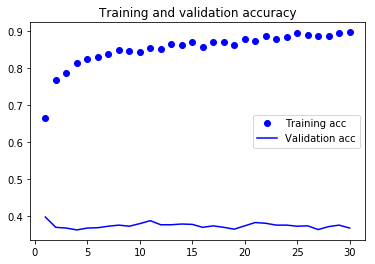

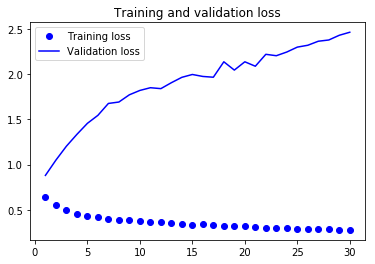

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Freezing all layers up to a specific one

In [10]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 13s 133ms/step - loss: 0.2348 - acc: 0.9055 - val_loss: 4.0624 - val_acc: 0.3760
Epoch 2/100
100/100 [==============================] - 13s 127ms/step - loss: 0.1940 - acc: 0.9265 - val_loss: 5.1203 - val_acc: 0.3530
Epoch 3/100
100/100 [==============================] - 13s 127ms/step - loss: 0.1407 - acc: 0.9510 - val_loss: 5.5149 - val_acc: 0.3230
Epoch 4/100
100/100 [==============================] - 13s 128ms/step - loss: 0.1318 - acc: 0.9500 - val_loss: 5.8368 - val_acc: 0.3420
Epoch 5/100
100/100 [==============================] - 13s 128ms/step - loss: 0.1070 - acc: 0.9595 - val_loss: 6.2172 - val_acc: 0.3750
Epoch 6/100
100/100 [==============================] - 13s 128ms/step - loss: 0.1011 - acc: 0.9690 - val_loss: 6.0962 - val_acc: 0.3440
Epoch 7/100
100/100 [==============================] - 13s 128ms/step - loss: 0.0816 - acc: 0.9680 - val_loss: 6.0881 - val_acc: 0.3360
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0137 - acc: 0.9950 - val_loss: 8.1945 - val_acc: 0.3510
Epoch 62/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0094 - acc: 0.9975 - val_loss: 7.5164 - val_acc: 0.3870
Epoch 63/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0145 - acc: 0.9945 - val_loss: 8.1091 - val_acc: 0.3800
Epoch 64/100
100/100 [==============================] - 13s 128ms/step - loss: 0.0052 - acc: 0.9985 - val_loss: 7.9327 - val_acc: 0.3790
Epoch 65/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0113 - acc: 0.9965 - val_loss: 8.0201 - val_acc: 0.3420
Epoch 66/100
100/100 [==============================] - 13s 127ms/step - loss: 0.0060 - acc: 0.9980 - val_loss: 8.2197 - val_acc: 0.3430
Epoch 67/100
100/100 [==============================] - 13s 128ms/step - loss: 0.0132 - acc: 0.9945 - val_loss: 8.1577 - val_acc: 0.3500
Epoch 68/100
100/100 [===================

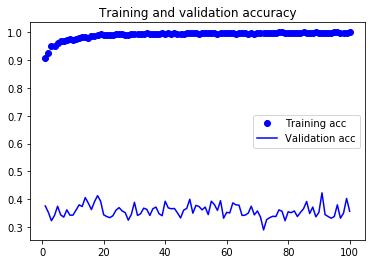

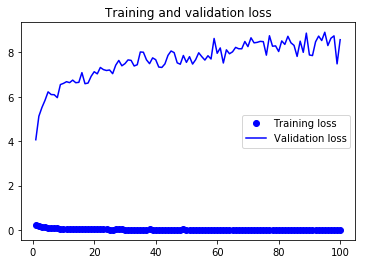

In [13]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
model.save('V1_FrozenVGG_Small.h5')
model.save_weights('V1_FrozenVGG_Small_Weights.h5')

In [18]:
test_dir = '/Code/dua/602020_Split/small sample/Relocated_Data2/Test'
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(90, 80),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 600 images belonging to 2 classes.
test acc: 0.521000007391
